# 概要
リザバー(サブネットワーク)におけるどの特徴量が$\mu_p, \sigma_p^2$に対応しているのかを調べる。

In [117]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN, RNNSimple
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

In [118]:
sigma_sq = 0.5

In [119]:
def make_signal_for_prior(time_length, mu_p, sigma_p, uncertainty=0.5, g=1.25):
    input_signals = np.zeros([1, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    
    state = State(mu=mu_p, sigma=sigma_p)
    
    for i in range(1):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = state()
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals

In [120]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220428_4/20220428_4.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220428_4


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [121]:
sigma_l = math.sqrt(1/1.25) * 0.5
mu_p_list = []
sigma_p_list = []

neural_states = np.zeros((300, 30, 200))
reservoir_states = np.zeros((300, 30, 50))
for i in range(300):
    mu_p = np.random.rand()-0.5
    sigma_p = np.random.rand()*0.8
    mu_p_list.append(mu_p)
    sigma_p_list.append(sigma_p)
    input_signal = make_signal_for_prior(
        time_length=50, 
        mu_p=mu_p,
        sigma_p=sigma_p,
        uncertainty=0.5,
        g=1.25,
    )
    inputs = torch.from_numpy(input_signal).float()                                 
    inputs = inputs.to(device) 
    hidden_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))
    reservoir_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))
         
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device) 
    reservoir = torch.from_numpy(reservoir_np).float()
    reservoir = reservoir.to(device)
    hidden_list, _, _, reservoir_list = model(inputs, hidden, reservoir, 50) 
        
    neural_dynamics = hidden_list.cpu().detach().numpy()   
    reservoir_dynamics = reservoir_list.cpu().detach().numpy()
        
    neural_states[i] = neural_dynamics[0, -30:]
    reservoir_states[i] = reservoir_dynamics[0, -30:]

In [122]:
neural_states_all = neural_states.reshape(300*30, 200)
reservoir_states_all = reservoir_states.reshape(300*30, 50)

## sub network

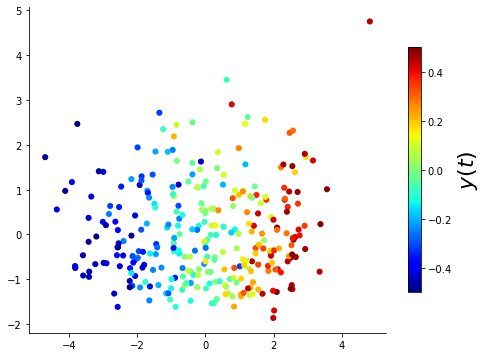

In [123]:
pca_sub = PCA(n_components=3)
pca_sub.fit(reservoir_states_all)

trajectory = pca_sub.transform(reservoir_states_all)

fig = plt.figure(figsize=(8, 6))

internal_dynamics = plt.scatter(
    trajectory[25::30, 0], 
    trajectory[25::30, 1],  
    c=mu_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$y(t)$', fontsize=22)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

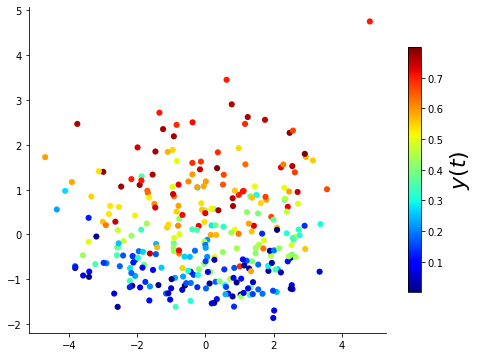

In [124]:
fig = plt.figure(figsize=(8, 6))

internal_dynamics = plt.scatter(
    trajectory[25::30, 0], 
    trajectory[25::30, 1],  
    c=sigma_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$y(t)$', fontsize=22)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

### $\mu_p$と関係するfactor

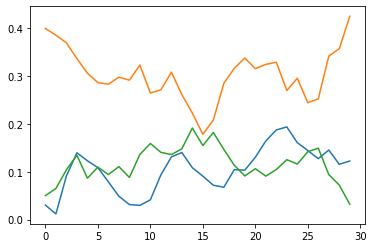

In [125]:
plt.plot(reservoir_states[0, :, 0])
plt.plot(reservoir_states[0, :, 1])
plt.plot(reservoir_states[0, :, 2])

In [126]:
mu_p_list[0]

-0.4047212859635134

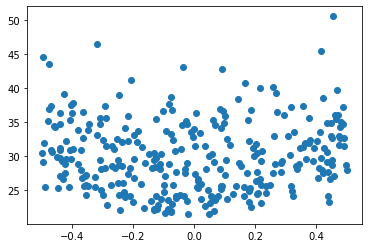

In [127]:
plt.scatter(
    mu_p_list,
    np.linalg.norm(reservoir_states, axis=(1, 2)),
)

Text(0.5, 0, '$\\sigma_p$')

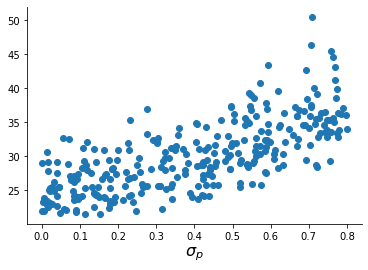

In [133]:
plt.scatter(
    sigma_p_list,
    np.linalg.norm(reservoir_states, axis=(1, 2)),
)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel(r'$\sigma_p$', fontsize=16)


In [129]:
np.linalg.norm(reservoir_states[6], axis=0)

array([ 0.53823823,  1.49800446,  0.32532703,  0.48300308,  4.33704317,
        3.02385398,  0.5926295 ,  0.29515035,  0.45349817, 10.45029425,
        7.18940047,  0.43271339,  0.38611138,  0.55764751,  0.27088706,
        0.74047784, 11.6327476 ,  0.26027475,  1.66704834,  1.50235999,
        6.8344186 ,  0.45184985,  4.45154543,  8.66989439,  6.60312551,
        1.71718709, 11.1130348 ,  1.11776991,  1.99541757,  0.36279195,
        5.91757113,  1.30121772,  0.21381199, 11.92706731, 13.77391115,
        5.91620544,  3.79324158,  0.53326829, 11.25666589,  9.34948807,
        2.08776952,  3.8866138 ,  0.92714119,  0.34452924,  0.44696613,
        2.16441809,  0.32755831,  0.44906417,  0.57161023,  1.97843699])

In [130]:
np.linalg.norm(reservoir_states[2], axis=0)

array([ 0.41602295,  1.31869235,  0.29720477,  0.37153809,  3.78986806,
        1.39870986,  0.25358593,  0.28666007,  0.40521035,  6.85491885,
        7.60929994,  0.3725802 ,  0.45134545,  0.34213363,  0.48425077,
        0.35302629,  8.4682286 ,  0.56050935,  3.40609169,  1.1978914 ,
        4.8075456 ,  0.56512756,  2.41869361,  8.23017969,  6.61494031,
        1.4874662 ,  8.05405847,  2.1326401 ,  1.68706595,  0.28808818,
        5.53665235,  0.22575213,  0.53179006, 11.17624274, 13.65659825,
        3.62286661,  4.27128147,  0.47522667, 11.15605473,  6.33782126,
        0.93218386,  2.42227455,  0.62534898,  0.20879678,  0.46816995,
        1.04072903,  0.35948763,  0.26412153,  0.23093781,  0.86160668])

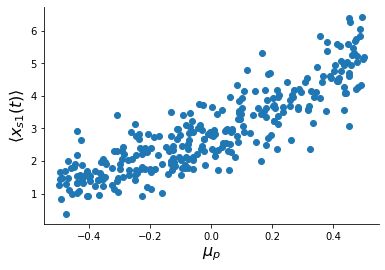

In [141]:
plt.scatter(
    mu_p_list,
    np.linalg.norm(reservoir_states[:, :, 1], axis=1),
)


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel(r'$\mu_p$', fontsize=16)
plt.ylabel(r'$\langle x_{s1}(t) \rangle$', fontsize=16)

plt.savefig('results/20220531/x_s1.png', dpi=200)

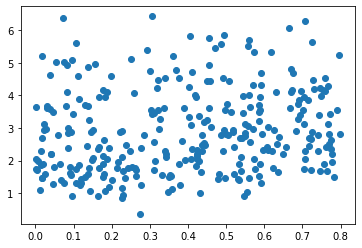

In [132]:
plt.scatter(
    sigma_p_list,
    np.linalg.norm(reservoir_states[:, :, 1], axis=1),
)

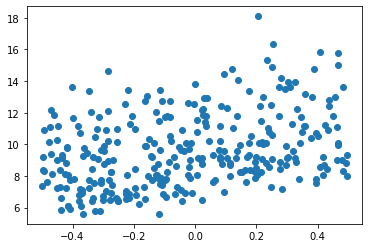

In [24]:
plt.scatter(
    mu_p_list,
    np.linalg.norm(reservoir_states[:, :, 9], axis=1),
)

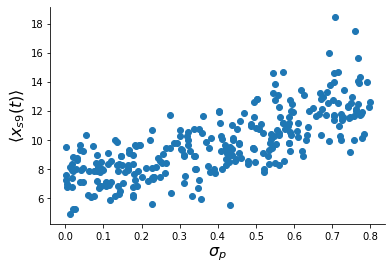

In [138]:
plt.scatter(
    sigma_p_list,
    np.linalg.norm(reservoir_states[:, :, 9], axis=1),
)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel(r'$\sigma_p$', fontsize=16)
plt.ylabel(r'$\langle x_{s9}(t) \rangle$', fontsize=16)

plt.savefig('results/20220531/x_s9.png', dpi=200)

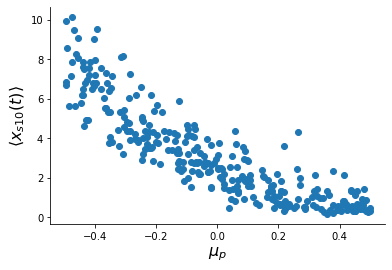

In [140]:
plt.scatter(
    mu_p_list,
    np.linalg.norm(reservoir_states[:, :, 10], axis=1),
)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel(r'$\mu_p$', fontsize=16)
plt.ylabel(r'$\langle x_{s10}(t) \rangle$', fontsize=16)

plt.savefig('results/20220531/x_s10.png', dpi=200)

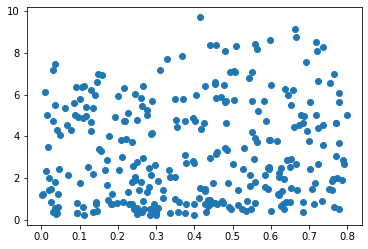

In [28]:
plt.scatter(
    sigma_p_list,
    np.linalg.norm(reservoir_states[:, :, 10], axis=1),
)

## 未知の環境へと移行する場合

In [108]:
def make_signal(N, time_length, state_list, uncertainty=0.5):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    g = 1.25
    target_list = np.zeros([N, 400])
    signal_mu_list = np.zeros((N, time_length))
    true_signal_list = np.zeros((N, time_length))
    
    for i in range(N):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            if t <= 50:
                true_signal = state_list[0]()
            elif t <= 70:
                true_signal = state_list[1]()
            else:
                true_signal = state_list[0]()
            true_signal_list[i, t] = true_signal
            
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            signal_mu_list[i, t] = signal_mu
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals, true_signal_list, signal_mu_list

In [109]:
state_list = [
    State(mu=0.4, sigma=0.8),
    State(mu=-0.4, sigma=0.1),
]

In [110]:
sample_num = 5
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=100, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))

# 時間スケールに差があるモデル
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_slow, prior_list, reservoir_list = model(inputs, hidden, reservoir, 100)                                                       


In [111]:
reservoir_sample = reservoir_list.detach().numpy()

(0.0, 1.5)

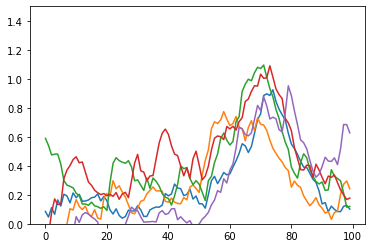

In [112]:
plt.plot(reservoir_sample[0, :, 10])
plt.plot(reservoir_sample[1, :, 10])
plt.plot(reservoir_sample[2, :, 10])
plt.plot(reservoir_sample[3, :, 10])
plt.plot(reservoir_sample[4, :, 10])

plt.ylim([0, 1.5])

In [113]:
def make_signal(N, time_length, state_list, uncertainty=0.5, interval=20):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    g = 1.25
    target_list = np.zeros([N, 400])
    signal_mu_list = np.zeros((N, time_length))
    true_signal_list = np.zeros((N, time_length))
    
    for i in range(N):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            if (t // interval) % 2:
                true_signal = state_list[0]()
            else:
                true_signal = state_list[1]()
            true_signal_list[i, t] = true_signal
            
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            signal_mu_list[i, t] = signal_mu
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals, true_signal_list, signal_mu_list

In [114]:
state_list = [
    State(mu=0.4, sigma=0.8),
    State(mu=-0.4, sigma=0.1),
]

In [115]:
sample_num = 5
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=240, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))

# 時間スケールに差があるモデル
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_slow, prior_list, reservoir_list = model(inputs, hidden, reservoir, 240)                                                       


(0.0, 1.5)

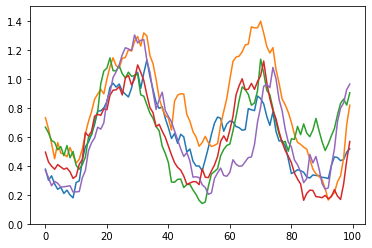

In [116]:
reservoir_sample = reservoir_list.detach().numpy()

plt.plot(reservoir_sample[0, 110:210, 10])
plt.plot(reservoir_sample[1, 110:210, 10])
plt.plot(reservoir_sample[2, 110:210, 10])
plt.plot(reservoir_sample[3, 110:210, 10])
plt.plot(reservoir_sample[4, 110:210, 10])

plt.ylim([0, 1.5])

(0.0, 1.5)

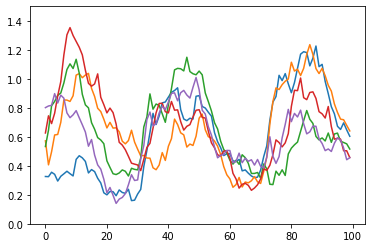

In [98]:
plt.plot(reservoir_sample[0, 110:210, 1])
plt.plot(reservoir_sample[1, 110:210, 1])
plt.plot(reservoir_sample[2, 110:210, 1])
plt.plot(reservoir_sample[3, 110:210, 1])
plt.plot(reservoir_sample[4, 110:210, 1])

plt.ylim([0, 1.5])